In [ ]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

In [ ]:
from pyomo.environ import *

# Initialize model
model = ConcreteModel()

# Data
designs = [
    {"id": "D1", "colors": 3, "pieces": 31548},
    {"id": "D2", "colors": 4, "pieces": 75475},
    {"id": "D3", "colors": 12, "pieces": 10908},
    {"id": "D4", "colors": 8, "pieces": 51310},
    {"id": "D5", "colors": 12, "pieces": 4533},
    {"id": "D6", "colors": 12, "pieces": 103918},
    {"id": "D7", "colors": 7, "pieces": 48537},
    {"id": "D8", "colors": 12, "pieces": 52959},
    {"id": "D9", "colors": 16, "pieces": 710},
    {"id": "D10", "colors": 14, "pieces": 70386},
    {"id": "D11", "colors": 7, "pieces": 13164},
    {"id": "D12", "colors": 12, "pieces": 38048},
    {"id": "D13", "colors": 14, "pieces": 2688},
    {"id": "D14", "colors": 14, "pieces": 121016},
    {"id": "D15", "colors": 11, "pieces": 31889},
    {"id": "D16", "colors": 16, "pieces": 9817},
    {"id": "D17", "colors": 16, "pieces": 46304},
    {"id": "D18", "colors": 17, "pieces": 17830},
    {"id": "D19", "colors": 15, "pieces": 26943},
    {"id": "D20", "colors": 18, "pieces": 12388},
    {"id": "D21", "colors": 13, "pieces": 60256},
    {"id": "D22", "colors": 18, "pieces": 50722},
    {"id": "D23", "colors": 17, "pieces": 5279},
    {"id": "D24", "colors": 18, "pieces": 81181},
    {"id": "D25", "colors": 5, "pieces": 32191},
]

machines = [
    {"id": "M1", "max_colors": 12, "output_per_hour": 600, "fixed_cost": 150},
    {"id": "M2", "max_colors": 12, "output_per_hour": 600, "fixed_cost": 150},
    {"id": "M3", "max_colors": 14, "output_per_hour": 590, "fixed_cost": 150},
    {"id": "M4", "max_colors": 14, "output_per_hour": 590, "fixed_cost": 150},
    {"id": "M5", "max_colors": 16, "output_per_hour": 575, "fixed_cost": 150},
    {"id": "M6", "max_colors": 16, "output_per_hour": 575, "fixed_cost": 150},
    {"id": "M7", "max_colors": 16, "output_per_hour": 575, "fixed_cost": 150},
    {"id": "M8", "max_colors": 18, "output_per_hour": 550, "fixed_cost": 150},
    {"id": "M9", "max_colors": 18, "output_per_hour": 550, "fixed_cost": 150},
]

setup_time_per_color = 10 / 60  # hours
setup_cost_per_minute = 2.0  # dollars
ink_cost_per_piece = 0.10  # dollars
revenue_per_piece = 0.45  # dollars

# Sets
model.D = RangeSet(len(designs))  # Designs
model.M = RangeSet(len(machines))  # Machines

# Parameters
design_colors = {i + 1: designs[i]["colors"] for i in range(len(designs))}
design_pieces = {i + 1: designs[i]["pieces"] for i in range(len(designs))}
machine_colors = {j + 1: machines[j]["max_colors"] for j in range(len(machines))}
machine_output = {j + 1: machines[j]["output_per_hour"] for j in range(len(machines))}
machine_cost = {j + 1: machines[j]["fixed_cost"] for j in range(len(machines))}

# Decision Variables
model.x = Var(model.D, model.M, domain=Binary)  # 1 if design d is assigned to machine m
model.time = Var(model.M, domain=NonNegativeReals)  # Total time machine m is used
model.max_time = Var(domain=NonNegativeReals)  # Maximum machine time
model.min_time = Var(domain=NonNegativeReals)  # Minimum machine time

# Objective Function: Maximize profit
def profit_rule(model):
    revenue = sum(design_pieces[d] * revenue_per_piece for d in model.D)
    setup_cost = sum(model.x[d, m] * design_colors[d] * setup_time_per_color * setup_cost_per_minute for d in model.D for m in model.M)
    ink_cost = sum(model.x[d, m] * design_pieces[d] * ink_cost_per_piece for d in model.D for m in model.M)
    fixed_cost = sum(model.time[m] * machine_cost[m] for m in model.M)
    return revenue - (setup_cost + ink_cost + fixed_cost)

model.profit = Objective(rule=profit_rule, sense=maximize)

# Constraints
# 1. Each design is assigned to one machine
def assignment_rule(model, d):
    return sum(model.x[d, m] for m in model.M) == 1

model.assignment = Constraint(model.D, rule=assignment_rule)

# 2. Machine color capacity
def color_capacity_rule(model, d, m):
    return model.x[d, m] * design_colors[d] <= machine_colors[m]

model.color_capacity = Constraint(model.D, model.M, rule=color_capacity_rule)

# 3. Machine time usage
def machine_time_rule(model, m):
    return model.time[m] >= sum(model.x[d, m] * design_pieces[d] / machine_output[m] for d in model.D)

model.machine_time = Constraint(model.M, rule=machine_time_rule)

# 4. Define max_time and min_time
def max_time_rule(model, m):
    return model.max_time >= model.time[m]

def min_time_rule(model, m):
    return model.min_time <= model.time[m]

model.max_time_constraint = Constraint(model.M, rule=max_time_rule)
model.min_time_constraint = Constraint(model.M, rule=min_time_rule)

# 5. Workload balance constraint
def workload_balance_rule(model):
    return model.max_time <= 1.25 * model.min_time

model.workload_balance = Constraint(rule=workload_balance_rule)

# Solve the model
solver = SolverFactory('cbc')  # Use CBC solver
results = solver.solve(model, tee=True)

# Display results
print("Profit:", model.profit())
for d in model.D:
    for m in model.M:
        if model.x[d, m].value == 1:
            print(f"Design {d} assigned to Machine {m}")


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /content/bin/cbc -printingOptions all -import /tmp/tmp9t0u3qja.pyomo.lp -stat=1 -solve -solu /tmp/tmp9t0u3qja.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve is modifying 59 integer bounds and re-presolving
Presolve 48 (-230) rows, 172 (-65) columns and 369 (-353) elements
Statistics for presolved model
Original problem has 166 integers (166 of which binary)
Presolved problem has 161 integers (161 of which binary)
==== 7 zero objective 22 different
==== absolute objective values 22 different
==== for integers 5 zero objective 21 different
==== for integers absolute objective values 21 different
===== end objective counts


Problem has 48 rows, 172 columns (165 with objective) and 369 elements
Column breakdown:
11 of

In [ ]:
# Machine performance summary
print("\nMachine Performance Summary:")
for m in model.M:
    # Calculate total pieces printed by machine m
    pieces_printed = sum(model.x[d, m].value * design_pieces[d] for d in model.D)

    # Count the number of designs assigned to the machine
    designs_assigned = sum(1 for d in model.D if model.x[d, m].value == 1)

    # Calculate machine's setup cost
    setup_cost = sum(model.x[d, m].value * design_colors[d] * setup_time_per_color * setup_cost_per_minute for d in model.D)

    # Calculate machine's ink cost
    ink_cost = pieces_printed * ink_cost_per_piece

    # Calculate machine's fixed cost
    fixed_cost = model.time[m].value * machine_cost[m]

    # Calculate total cost for the machine
    total_cost = setup_cost + ink_cost + fixed_cost

    # Calculate revenue generated by the machine
    revenue = pieces_printed * revenue_per_piece

    # Calculate profit for the machine
    profit = revenue - total_cost

    # Calculate hours worked by the machine
    hours_worked = model.time[m].value

    # Print the machine's performance
    print(f"Machine {m}:")
    print(f"  Number of Designs Assigned: {designs_assigned}")
    print(f"  Pieces Printed: {pieces_printed}")
    print(f"  Hours Worked: {hours_worked:.2f} hours")
    print(f"  Revenue: ${revenue:.2f}")
    print(f"  Setup Cost: ${setup_cost:.2f}")
    print(f"  Ink Cost: ${ink_cost:.2f}")
    print(f"  Fixed Cost: ${fixed_cost:.2f}")
    print(f"  Total Cost: ${total_cost:.2f}")
    print(f"  Profit: ${profit:.2f}\n")



Machine Performance Summary:
Machine 1:
  Number of Designs Assigned: 2
  Pieces Printed: 126785.0
  Hours Worked: 211.31 hours
  Revenue: $57053.25
  Setup Cost: $4.00
  Ink Cost: $12678.50
  Fixed Cost: $31696.25
  Total Cost: $44378.75
  Profit: $12674.50

Machine 2:
  Number of Designs Assigned: 4
  Pieces Printed: 127429.0
  Hours Worked: 212.38 hours
  Revenue: $57343.05
  Setup Cost: $15.67
  Ink Cost: $12742.90
  Fixed Cost: $31857.25
  Total Cost: $44615.82
  Profit: $12727.23

Machine 3:
  Number of Designs Assigned: 2
  Pieces Printed: 123704.0
  Hours Worked: 209.67 hours
  Revenue: $55666.80
  Setup Cost: $9.33
  Ink Cost: $12370.40
  Fixed Cost: $31450.17
  Total Cost: $43829.90
  Profit: $11836.90

Machine 4:
  Number of Designs Assigned: 4
  Pieces Printed: 125440.0
  Hours Worked: 212.61 hours
  Revenue: $56448.00
  Setup Cost: $7.33
  Ink Cost: $12544.00
  Fixed Cost: $31891.53
  Total Cost: $44442.86
  Profit: $12005.14

Machine 5:
  Number of Designs Assigned: 1
  

In [ ]:
# Table to show designs for each machine, total pieces, and profit
from prettytable import PrettyTable

# Initialize the table
table = PrettyTable()
table.field_names = ["Machine", "Designs Assigned", "Total Pieces", "Profit ($)"]

# Iterate through machines
for m in model.M:
    # Get the designs assigned to the machine
    assigned_designs = [f"D{d}" for d in model.D if model.x[d, m].value == 1]

    # Calculate total pieces printed by the machine
    total_pieces = sum(model.x[d, m].value * design_pieces[d] for d in model.D)

    # Calculate setup cost
    setup_cost = sum(model.x[d, m].value * design_colors[d] * setup_time_per_color * setup_cost_per_minute for d in model.D)

    # Calculate ink cost
    ink_cost = total_pieces * ink_cost_per_piece

    # Calculate fixed cost
    fixed_cost = model.time[m].value * machine_cost[m]

    # Calculate total cost
    total_cost = setup_cost + ink_cost + fixed_cost

    # Calculate revenue
    revenue = total_pieces * revenue_per_piece

    # Calculate profit
    profit = revenue - total_cost

    # Add the data to the table
    table.add_row([f"M{m}", ", ".join(assigned_designs), int(total_pieces), f"{profit:.2f}"])

# Print the table
print("\nMachine Performance Summary:")
print(table)



Machine Performance Summary:
+---------+------------------------+--------------+------------+
| Machine |    Designs Assigned    | Total Pieces | Profit ($) |
+---------+------------------------+--------------+------------+
|    M1   |         D2, D4         |    126785    |  12674.50  |
|    M2   |    D5, D8, D12, D15    |    127429    |  12727.23  |
|    M3   |        D13, D14        |    123704    |  11836.90  |
|    M4   |    D1, D7, D11, D25    |    125440    |  12005.14  |
|    M5   |           D6           |    103918    |  9258.26   |
|    M6   |      D9, D10, D19      |    98039     |  8723.26   |
|    M7   |        D17, D21        |    106560    |  9488.07   |
|    M8   | D3, D16, D18, D22, D23 |    94556     |  7279.93   |
|    M9   |        D20, D24        |    93569     |  7218.33   |
+---------+------------------------+--------------+------------+


In [ ]:
# Calculate total profit
total_revenue = sum(design_pieces[d] * revenue_per_piece for d in model.D)
total_setup_cost = sum(model.x[d, m].value * design_colors[d] * setup_time_per_color * setup_cost_per_minute for d in model.D for m in model.M)
total_ink_cost = sum(model.x[d, m].value * design_pieces[d] * ink_cost_per_piece for d in model.D for m in model.M)
total_fixed_cost = sum(model.time[m].value * machine_cost[m] for m in model.M)

total_cost = total_setup_cost + total_ink_cost + total_fixed_cost
total_profit = total_revenue - total_cost

# Print the total profit
print("\nOverall Performance Summary:")
print(f"Total Revenue: ${total_revenue:.2f}")
print(f"Total Setup Cost: ${total_setup_cost:.2f}")
print(f"Total Ink Cost: ${total_ink_cost:.2f}")
print(f"Total Fixed Cost: ${total_fixed_cost:.2f}")
print(f"Total Cost: ${total_cost:.2f}")
print(f"Total Profit: ${total_profit:.2f}")



Overall Performance Summary:
Total Revenue: $450000.00
Total Setup Cost: $103.67
Total Ink Cost: $100000.00
Total Fixed Cost: $258684.71
Total Cost: $358788.38
Total Profit: $91211.62


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_visualization_report():
    # Data preparation
    machine_data = [
        {"machine": "M1", "designs": 2, "pieces": 126785, "time": 211.31, "profit": 12674.50,
         "revenue": 57053.25, "setup_cost": 4.00, "ink_cost": 12678.50, "fixed_cost": 31696.25},
        {"machine": "M2", "designs": 4, "pieces": 127429, "time": 212.38, "profit": 12727.23,
         "revenue": 57343.05, "setup_cost": 15.67, "ink_cost": 12742.90, "fixed_cost": 31857.25},
        {"machine": "M3", "designs": 2, "pieces": 123704, "time": 209.67, "profit": 11836.90,
         "revenue": 55666.80, "setup_cost": 9.33, "ink_cost": 12370.40, "fixed_cost": 31450.17},
        {"machine": "M4", "designs": 4, "pieces": 125440, "time": 212.61, "profit": 12005.14,
         "revenue": 56448.00, "setup_cost": 7.33, "ink_cost": 12544.00, "fixed_cost": 31891.53},
        {"machine": "M5", "designs": 1, "pieces": 103918, "time": 180.73, "profit": 9258.26,
         "revenue": 46763.10, "setup_cost": 4.00, "ink_cost": 10391.80, "fixed_cost": 27109.04},
        {"machine": "M6", "designs": 3, "pieces": 98039, "time": 170.50, "profit": 8723.26,
         "revenue": 44117.55, "setup_cost": 15.00, "ink_cost": 9803.90, "fixed_cost": 25575.39},
        {"machine": "M7", "designs": 2, "pieces": 106560, "time": 185.32, "profit": 9488.07,
         "revenue": 47952.00, "setup_cost": 9.67, "ink_cost": 10656.00, "fixed_cost": 27798.26},
        {"machine": "M8", "designs": 5, "pieces": 94556, "time": 171.92, "profit": 7279.93,
         "revenue": 42550.20, "setup_cost": 26.67, "ink_cost": 9455.60, "fixed_cost": 25788.00},
        {"machine": "M9", "designs": 2, "pieces": 93569, "time": 170.13, "profit": 7218.33,
         "revenue": 42106.05, "setup_cost": 12.00, "ink_cost": 9356.90, "fixed_cost": 25518.82}
    ]

    try:
        # 1. Machine Performance Overview
        plt.figure(figsize=(15, 8))
        machines = [d['machine'] for d in machine_data]
        x = np.arange(len(machines))
        width = 0.2

        plt.bar(x - width*1.5, [d['pieces']/1000 for d in machine_data], width,
                label='Pieces (thousands)', color='skyblue')
        plt.bar(x - width/2, [d['time'] for d in machine_data], width,
                label='Hours Worked', color='lightgreen')
        plt.bar(x + width/2, [d['profit']/100 for d in machine_data], width,
                label='Profit (hundreds)', color='lightcoral')
        plt.bar(x + width*1.5, [d['designs'] for d in machine_data], width,
                label='Designs Assigned', color='gold')

        plt.xlabel('Machines')
        plt.ylabel('Values')
        plt.title('Machine Performance Overview')
        plt.xticks(x, machines)
        plt.legend()
        plt.tight_layout()
        plt.savefig('machine_performance.png')
        plt.close()

        # 2. Financial Breakdown per Machine
        plt.figure(figsize=(15, 8))
        x = np.arange(len(machines))
        width = 0.2

        plt.bar(x - width*1.5, [d['revenue'] for d in machine_data], width,
                label='Revenue', color='lightgreen')
        plt.bar(x - width/2, [d['fixed_cost'] for d in machine_data], width,
                label='Fixed Cost', color='lightcoral')
        plt.bar(x + width/2, [d['ink_cost'] for d in machine_data], width,
                label='Ink Cost', color='skyblue')
        plt.bar(x + width*1.5, [d['setup_cost'] for d in machine_data], width,
                label='Setup Cost', color='gold')

        plt.xlabel('Machines')
        plt.ylabel('Amount ($)')
        plt.title('Financial Breakdown per Machine')
        plt.xticks(x, machines)
        plt.legend()
        plt.tight_layout()
        plt.savefig('financial_breakdown.png')
        plt.close()

        # 3. Profit vs Time Scatter Plot
        plt.figure(figsize=(10, 8))
        times = [d['time'] for d in machine_data]
        profits = [d['profit'] for d in machine_data]
        pieces = [d['pieces'] for d in machine_data]

        plt.scatter(times, profits, s=[p/1000 for p in pieces], alpha=0.6)
        for i, machine in enumerate(machines):
            plt.annotate(machine, (times[i], profits[i]))

        plt.xlabel('Hours Worked')
        plt.ylabel('Profit ($)')
        plt.title('Profit vs Time (bubble size represents pieces printed)')
        plt.tight_layout()
        plt.savefig('profit_vs_time.png')
        plt.close()

        # 4. Cost Structure Overview
        plt.figure(figsize=(12, 8))

        total_costs = {'Setup Cost': sum(d['setup_cost'] for d in machine_data),
                      'Ink Cost': sum(d['ink_cost'] for d in machine_data),
                      'Fixed Cost': sum(d['fixed_cost'] for d in machine_data)}

        plt.pie(total_costs.values(), labels=total_costs.keys(), autopct='%1.1f%%',
                colors=['gold', 'skyblue', 'lightcoral'])
        plt.title('Overall Cost Structure')
        plt.savefig('cost_structure.png')
        plt.close()

        print("All visualizations have been saved successfully!")
        print("Files created: machine_performance.png, financial_breakdown.png, profit_vs_time.png, cost_structure.png")

        # Print overall statistics
        total_revenue = sum(d['revenue'] for d in machine_data)
        total_cost = sum(d['setup_cost'] + d['ink_cost'] + d['fixed_cost'] for d in machine_data)
        total_profit = sum(d['profit'] for d in machine_data)

        print("\nOverall Performance Summary:")
        print(f"Total Revenue: ${total_revenue:,.2f}")
        print(f"Total Cost: ${total_cost:,.2f}")
        print(f"Total Profit: ${total_profit:,.2f}")
        print(f"Average Profit per Machine: ${total_profit/9:,.2f}")

    except Exception as e:
        print(f"Error creating visualizations: {str(e)}")

# Create visualizations
create_visualization_report()

All visualizations have been saved successfully!
Files created: machine_performance.png, financial_breakdown.png, profit_vs_time.png, cost_structure.png

Overall Performance Summary:
Total Revenue: $450,000.00
Total Cost: $358,788.38
Total Profit: $91,211.62
Average Profit per Machine: $10,134.62


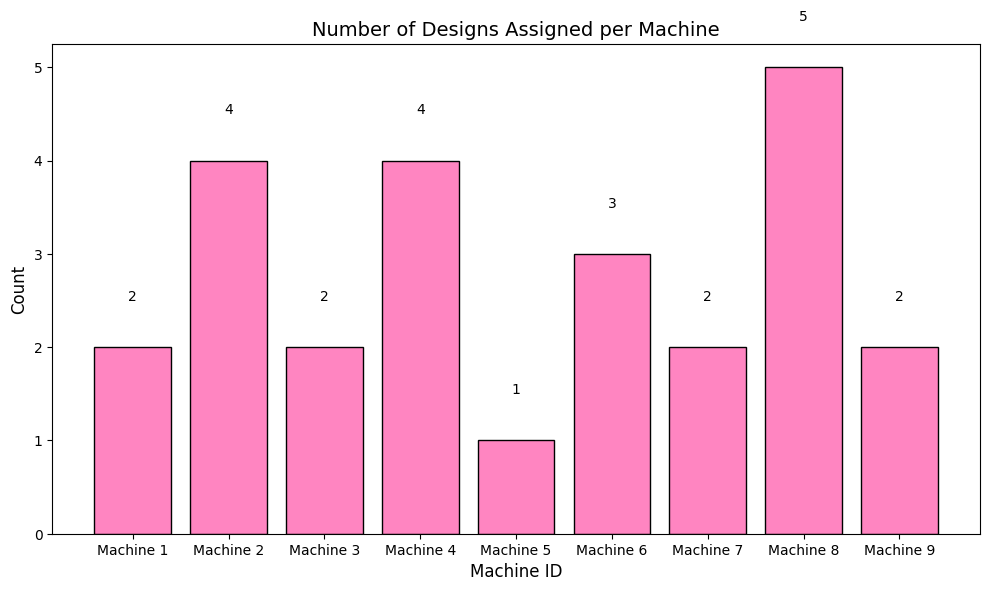

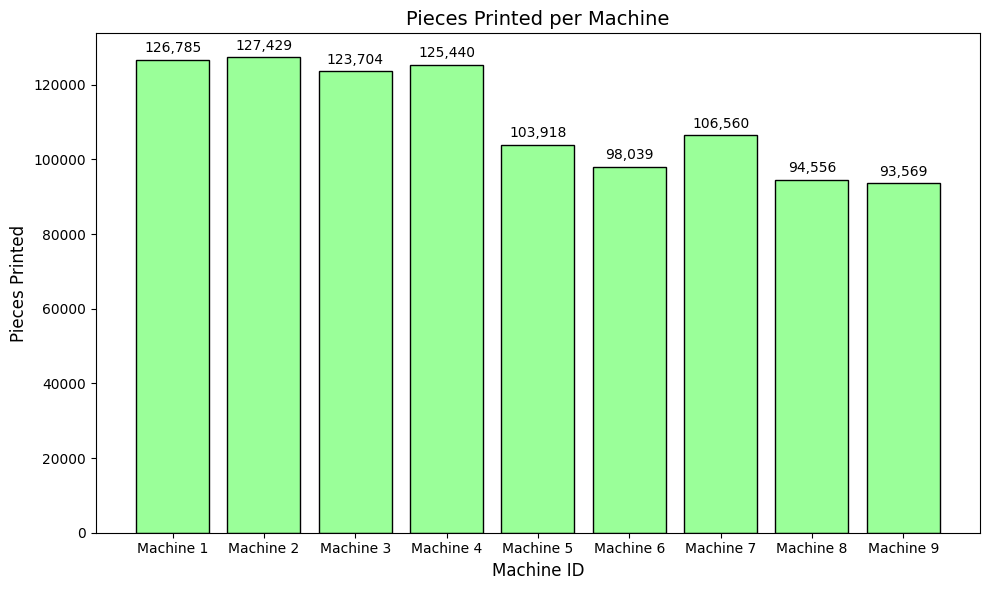

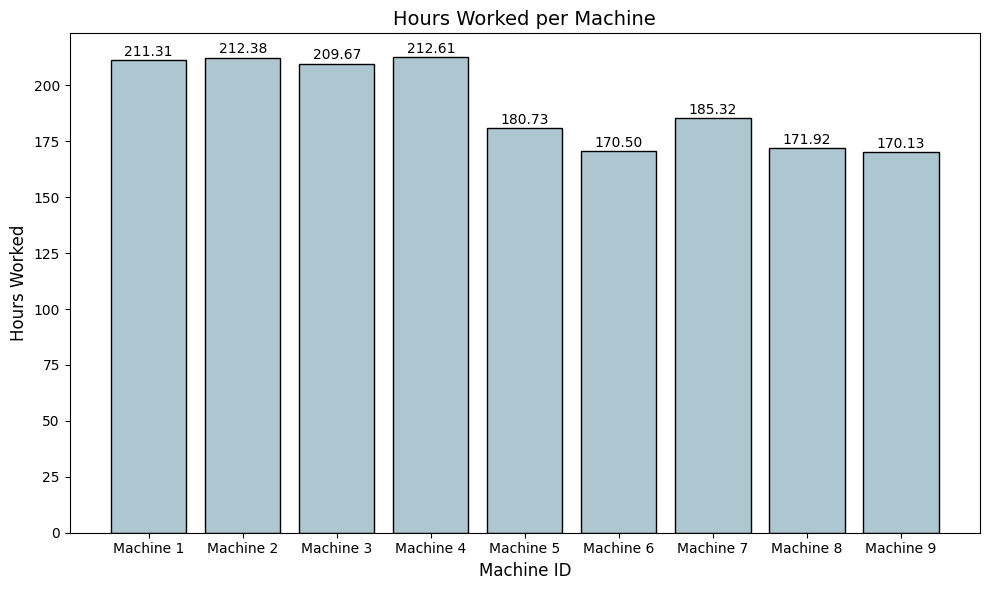

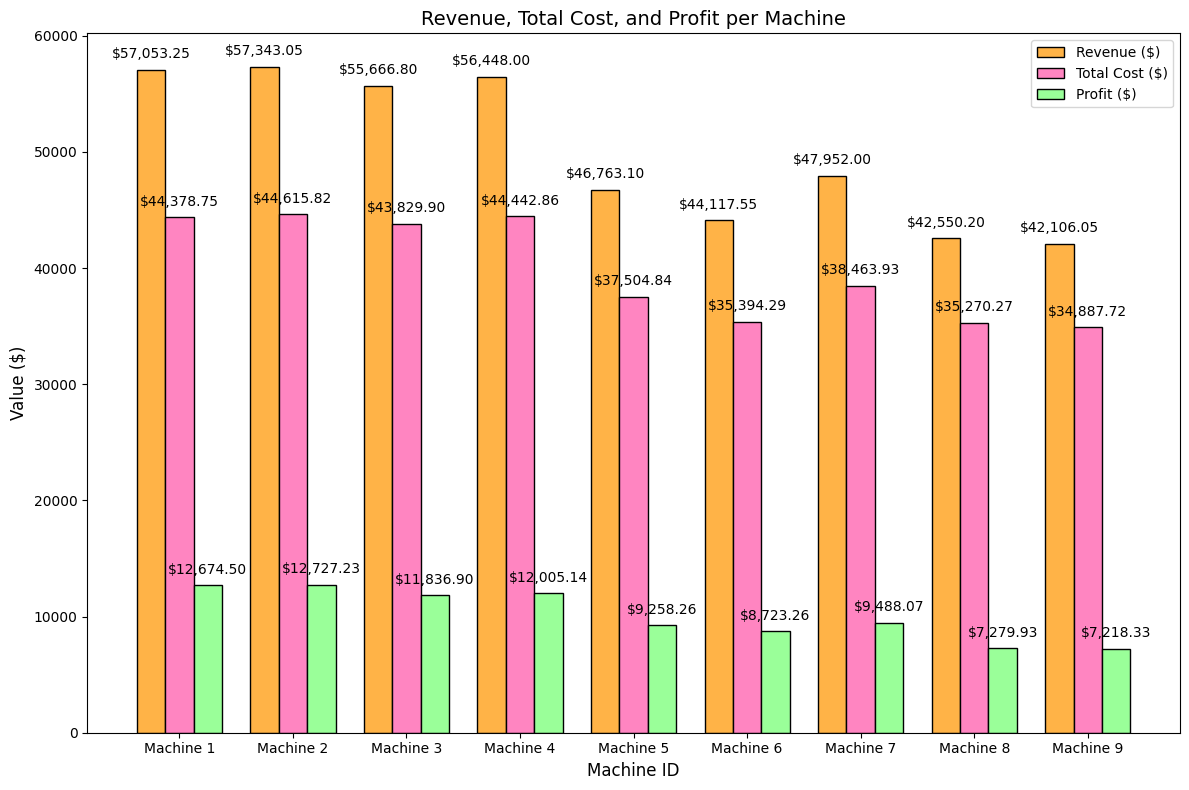

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_machine_performance(machine_data):
    # Extract data
    machine_ids = [f'Machine {i+1}' for i in range(len(machine_data))]
    designs_assigned = [data['designs_assigned'] for data in machine_data]
    pieces_printed = [data['pieces_printed'] for data in machine_data]
    hours_worked = [data['hours_worked'] for data in machine_data]
    revenue = [data['revenue'] for data in machine_data]
    total_cost = [data['total_cost'] for data in machine_data]
    profit = [data['profit'] for data in machine_data]

    # Bar width and positions
    bar_width = 0.25
    x = np.arange(len(machine_ids))

    # Plot 1: Number of Designs Assigned
    plt.figure(figsize=(10, 6))
    plt.bar(x, designs_assigned, color="#FF85C1", edgecolor="black", label="Designs Assigned")
    plt.xticks(x, machine_ids)
    plt.xlabel("Machine ID", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.title("Number of Designs Assigned per Machine", fontsize=14)
    for i, v in enumerate(designs_assigned):
        plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot 2: Pieces Printed
    plt.figure(figsize=(10, 6))
    plt.bar(x, pieces_printed, color="#9AFF99", edgecolor="black", label="Pieces Printed")
    plt.xticks(x, machine_ids)
    plt.xlabel("Machine ID", fontsize=12)
    plt.ylabel("Pieces Printed", fontsize=12)
    plt.title("Pieces Printed per Machine", fontsize=14)
    for i, v in enumerate(pieces_printed):
        plt.text(i, v + 2000, f'{v:,.0f}', ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot 3: Hours Worked
    plt.figure(figsize=(10, 6))
    plt.bar(x, hours_worked, color="#AEC6CF", edgecolor="black", label="Hours Worked")
    plt.xticks(x, machine_ids)
    plt.xlabel("Machine ID", fontsize=12)
    plt.ylabel("Hours Worked", fontsize=12)
    plt.title("Hours Worked per Machine", fontsize=14)
    for i, v in enumerate(hours_worked):
        plt.text(i, v + 2, f'{v:.2f}', ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot 4: Revenue, Total Cost, and Profit
    plt.figure(figsize=(12, 8))
    plt.bar(x - bar_width, revenue, bar_width, color="#FFB347", edgecolor="black", label="Revenue ($)")
    plt.bar(x, total_cost, bar_width, color="#FF85C1", edgecolor="black", label="Total Cost ($)")
    plt.bar(x + bar_width, profit, bar_width, color="#9AFF99", edgecolor="black", label="Profit ($)")
    plt.xticks(x, machine_ids)
    plt.xlabel("Machine ID", fontsize=12)
    plt.ylabel("Value ($)", fontsize=12)
    plt.title("Revenue, Total Cost, and Profit per Machine", fontsize=14)
    plt.legend()
    for i in range(len(machine_ids)):
        plt.text(i - bar_width, revenue[i] + 1000, f'${revenue[i]:,.2f}', ha='center', fontsize=10)
        plt.text(i, total_cost[i] + 1000, f'${total_cost[i]:,.2f}', ha='center', fontsize=10)
        plt.text(i + bar_width, profit[i] + 1000, f'${profit[i]:,.2f}', ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

# Data for each machine
machine_data = [
    {"designs_assigned": 2, "pieces_printed": 126785.0, "hours_worked": 211.31, "revenue": 57053.25, "total_cost": 44378.75, "profit": 12674.50},
    {"designs_assigned": 4, "pieces_printed": 127429.0, "hours_worked": 212.38, "revenue": 57343.05, "total_cost": 44615.82, "profit": 12727.23},
    {"designs_assigned": 2, "pieces_printed": 123704.0, "hours_worked": 209.67, "revenue": 55666.80, "total_cost": 43829.90, "profit": 11836.90},
    {"designs_assigned": 4, "pieces_printed": 125440.0, "hours_worked": 212.61, "revenue": 56448.00, "total_cost": 44442.86, "profit": 12005.14},
    {"designs_assigned": 1, "pieces_printed": 103918.0, "hours_worked": 180.73, "revenue": 46763.10, "total_cost": 37504.84, "profit": 9258.26},
    {"designs_assigned": 3, "pieces_printed": 98039.0, "hours_worked": 170.50, "revenue": 44117.55, "total_cost": 35394.29, "profit": 8723.26},
    {"designs_assigned": 2, "pieces_printed": 106560.0, "hours_worked": 185.32, "revenue": 47952.00, "total_cost": 38463.93, "profit": 9488.07},
    {"designs_assigned": 5, "pieces_printed": 94556.0, "hours_worked": 171.92, "revenue": 42550.20, "total_cost": 35270.27, "profit": 7279.93},
    {"designs_assigned": 2, "pieces_printed": 93569.0, "hours_worked": 170.13, "revenue": 42106.05, "total_cost": 34887.72, "profit": 7218.33}
]

# Plot machine performance
plot_machine_performance(machine_data)


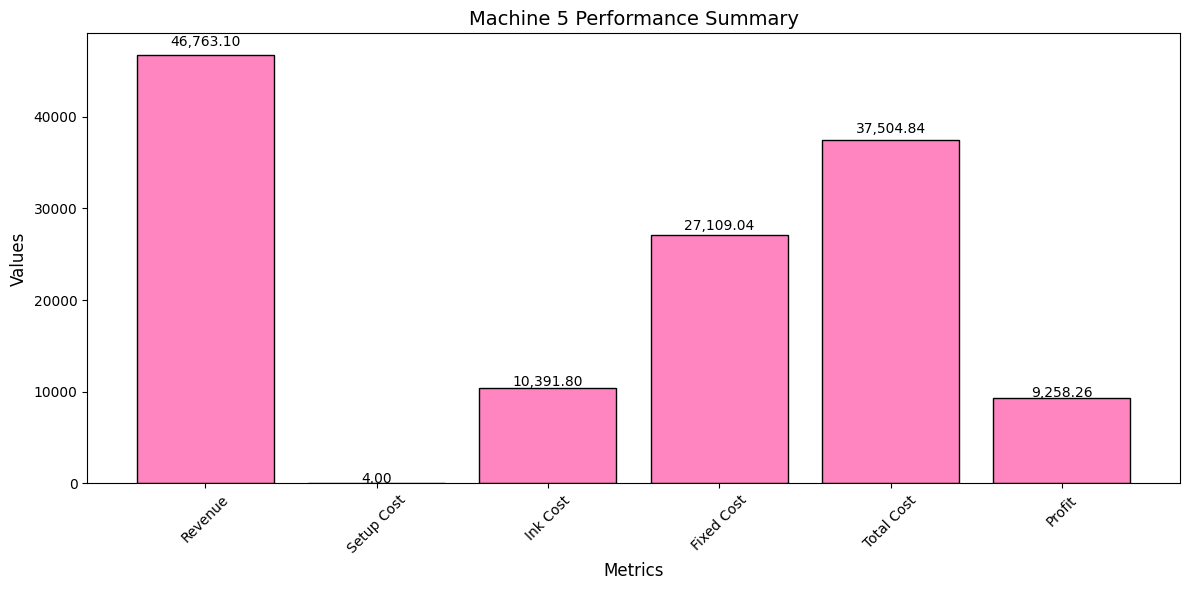

In [ ]:
import matplotlib.pyplot as plt

# Data for Machine 5
machine_5_data = {
    "metrics": [
        "Revenue",
        "Setup Cost",
        "Ink Cost",
        "Fixed Cost",
        "Total Cost",
        "Profit"
    ],
    "values": [
        46763.10,         # Revenue
        4.00,             # Setup Cost
        10391.80,         # Ink Cost
        27109.04,         # Fixed Cost
        37504.84,         # Total Cost
        9258.26           # Profit
    ]
}

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(machine_5_data["metrics"], machine_5_data["values"], color="#FF85C1", edgecolor="black")

# Add labels and title
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Machine 5 Performance Summary", fontsize=14)

# Add value annotations above the bars
for i, v in enumerate(machine_5_data["values"]):
    plt.text(i, v + (v * 0.02 if v > 100 else 10), f'{v:,.2f}', ha='center', fontsize=10)

# Adjust layout and display the plot
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()
